In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
file_path = './final_ipynb/'

In [3]:
# Retrieve the train and set data
x_train_df, y_train_df = pd.read_csv(file_path+'x_train.csv'), pd.read_csv(file_path+'y_train.csv')
x_test_df, y_test_df = pd.read_csv(file_path+'x_test.csv'), pd.read_csv(file_path+'y_test.csv')

In [4]:
# Save the name of the columns for XAI
pickle.dump(x_train_df.columns.values, open(file_path+'transformed_columns.pkl', 'wb'))

# Transform dataframe to numpy arrays for RL model
x_train, y_train = x_train_df.values, y_train_df.values.flatten()
x_test, y_test = x_test_df.values, y_test_df.values.flatten()

# Delete original dataframe to save memory
del x_train_df, y_train_df, x_test_df, y_test_df

In [5]:
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    mode='auto',
    restore_best_weights=True,
    verbose=2,
)

2023-02-26 14:57:44.829134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-26 14:57:44.829179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tfg-1): /proc/driver/nvidia/version does not exist
2023-02-26 14:57:44.829752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
ccw = compute_class_weight(class_weight='balanced', 
                          classes=np.unique(y_train), 
                          y=y_train)

cw = {i:w for i,w in enumerate(ccw)}

In [7]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[monitor],
    epochs=200,
    class_weight=cw,
    verbose=1,
    workers=8
)

Epoch 1/200
63502/63502 [==============================] - 69s 1ms/step - loss: 0.0207 - accuracy: 0.9892 - val_loss: 0.0433 - val_accuracy: 0.9816
Epoch 2/200
63502/63502 [==============================] - 71s 1ms/step - loss: 0.0188 - accuracy: 0.9895 - val_loss: 0.0429 - val_accuracy: 0.9816
Epoch 3/200
63502/63502 [==============================] - 69s 1ms/step - loss: 0.0184 - accuracy: 0.9895 - val_loss: 0.0467 - val_accuracy: 0.9815
Epoch 4/200
63502/63502 [==============================] - 69s 1ms/step - loss: 0.0179 - accuracy: 0.9895 - val_loss: 0.0423 - val_accuracy: 0.9817
Epoch 5/200
63502/63502 [==============================] - 69s 1ms/step - loss: 0.0177 - accuracy: 0.9896 - val_loss: 0.0468 - val_accuracy: 0.9816
Epoch 6/200
63502/63502 [==============================] - 69s 1ms/step - loss: 0.0175 - accuracy: 0.9896 - val_loss: 0.0403 - val_accuracy: 0.9817
Epoch 7/200
63502/63502 [==============================] - 68s 1ms/step - loss: 0.0178 - accuracy: 0.9896 - val_

In [11]:
y_pred = model.predict(x_test)

15876/15876 [==============================] - 61s 4ms/step


In [12]:
y_pred = np.rint(y_pred).astype(int)
y_pred = np.ravel(y_pred)

In [15]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred):
    # Macro-avg is recommended to keep minority classes relevant
    # Weighted-avg is recommended to keep majority classes relevant
    print(f'Metrics')
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, zero_division=0)
    pre = metrics.precision_score(y_truth, y_pred, zero_division=0)
    f1s = metrics.f1_score(y_truth, y_pred, zero_division=0)

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.3f')

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

Metrics


Accuracy     0.981687
Recall       0.999849
Precision    0.914295
F1-score     0.955160
Name: MLP, dtype: float64

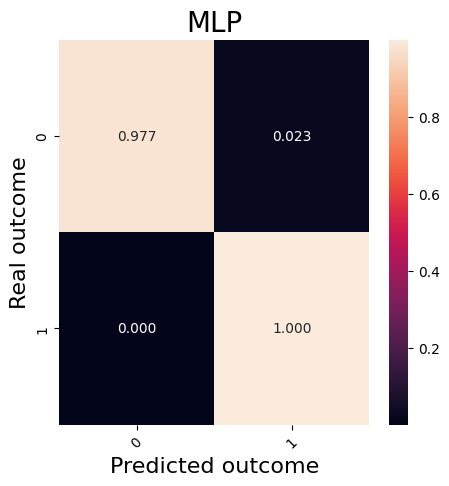

In [16]:
getMetrics('MLP', y_test, y_pred)
getCM('MLP', y_test, y_pred)

In [13]:
save_model(model, './Models/MLP.h5')

In [10]:
model = load_model('./Models/MLP.h5', compile=False)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)